# Description:
In this notebook the thermal noise temperature is determined from the timetraces that are used to make up the transit curves in order to have a better thermal noise temperature estimate for simulation.

# Import modules:

In [1]:
from GalaxyFunctions import *

# Import data

In [2]:
DataSample,StNr,ChNr,DataFileId="HC",23,16,"3277351-Tot"
FilteredEvNrs=np.load("JobResults/Data/St" + str(StNr) + "Ch" + str(ChNr) + "/" + DataSample + "FilteredEvNrs_" + str(DataFileId) + ".npy",allow_pickle=True)
FilteredRuns=np.load("JobResults/Data/St" + str(StNr) + "Ch" + str(ChNr) + "/" + DataSample + "FilteredRuns_" + str(DataFileId) + ".npy",allow_pickle=True)
GroupedVRMS=np.load("JobResults/Data/St" + str(StNr) + "Ch" + str(ChNr) + "/" + DataSample + "GroupedVRMS_" + str(DataFileId) + ".npy",allow_pickle=True)
MidBins=np.load("JobResults/Data/St" + str(StNr) + "Ch" + str(ChNr) + "/" + DataSample + "MidBins_" + str(DataFileId) + ".npy",allow_pickle=True)

# Compute Avg Vrms

According to (https://www.dxengineering.com/parts/cae-clp-5130-2n), the antenna bandwith is 105-1300 MHz.

In [3]:
#print(1e3*np.mean(np.concatenate(GroupedVRMS,axis=0)),"mV")
StNr,ZeroAvg=23,True
EventRMS=np.array([]) #Array to store V_RMS value of each event
for Run in FilteredRuns:
        path=Path(StNr,Run)
        #if os.path.isfile(path+"/combined.root"):
        if os.path.isfile(path+"/waveforms.root") and os.path.isfile(path+"/headers.root"):  
            #Read in data (RadiantData is read in on a per event basis in order to save memory)
            WaveFormFile=GetWaveformsFile(StNr,Run)
            EventNrs=WaveFormFile['event_number'].array(library="np")
            RunIdx=np.where(FilteredRuns==Run)[0][0]
            for EvNr in FilteredEvNrs[RunIdx]:
                EvIdx=np.where(EventNrs==EvNr)[0][0]
                RadiantData=WaveFormFile['radiant_data[24][2048]'].array(entry_start=EvIdx, entry_stop=EvIdx+1,library='np')
                #Check if the relevant timestamp is not inf or nan
                VoltageTrace=ADCtoVoltage(RadiantData[0][ChNr]) #Convert timetrace data from ADC to voltage (index on 0 since only one event is read in from WaveFormsFile)
                if ZeroAvg==True: #Zero average the timetrace 
                    Vmean=np.mean(VoltageTrace)
                    VoltageTrace-=Vmean
                EventRMS=np.append(EventRMS,np.sqrt(np.mean([V**2 for V in VoltageTrace])))
            del RadiantData, EventNrs, VoltageTrace
print(1e3*np.mean(EventRMS),"mV")

KeyboardInterrupt: 

In [ ]:
Df=1e6*(1300-105)
R=50
k=1.380649*1e-23
T=(Vrms**2)/(k*R*Df)
print()

In [25]:
TArray=np.array([[1,2],[3,4,5,6],[7,8,9]],dtype=object)
print(TArray)
TArray=np.concatenate(TArray,axis=0)
print(TArray)

[list([1, 2]) list([3, 4, 5, 6]) list([7, 8, 9])]
[1 2 3 4 5 6 7 8 9]


1.0

## Determine thermal noise temp from data:

In [32]:
from GalaxyFunctions import *
from NuRadioReco.detector import detector
from NuRadioReco.utilities import units
from datetime import datetime
import scipy.fft as scfft

StNr,ChNr,Run,EvNr,CutOff=22,7,101,19,1000

In [53]:
StNr,ChNr,Run,EvNr,CutOff=23,7,1,80,1000

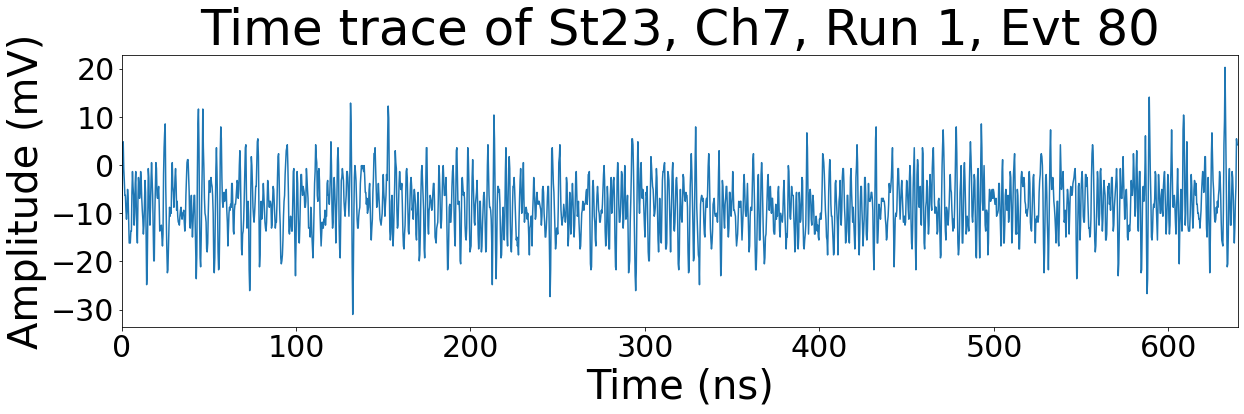

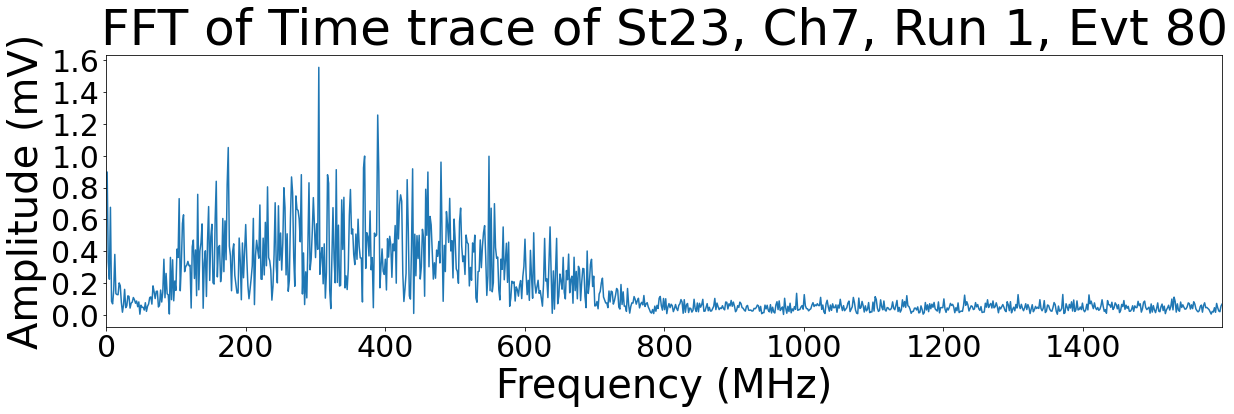

In [44]:
TimeTrace(StNr,ChNr,Run,EvNr,Amplitude="mV")
TimeTraceFFT(StNr,ChNr,Run,EvNr,Amplitude="mV")

In [45]:
WaveFormFile=GetWaveformsFile(StNr,Run)
EventNrs=WaveFormFile['event_number'].array(library="np")
EvIdx=np.where(EventNrs==EvNr)[0][0]
RadiantData=WaveFormFile['radiant_data[24][2048]'].array(entry_start=EvIdx, entry_stop=EvIdx+1,library='np')
HeaderFile=GetHeaderFile(StNr,Run)
TriggerTimes=HeaderFile["trigger_time"].array(library='np')
EvIdx=np.where(EventNrs==EvNr)[0][0]
RadiantData=WaveFormFile['radiant_data[24][2048]'].array(entry_start=EvIdx, entry_stop=EvIdx+1,library='np')
VoltageTrace=ADCtoVoltage(RadiantData[0][ChNr])

In [46]:
Date=datetime.utcfromtimestamp(TriggerTimes[EvIdx])# - timedelta(hours=2, minutes=0)
    
#Obtaining path to relevant json file for detector description
detpath = os.path.dirname(detector.__file__)
detpath+="/RNO_G/RNO_season_2022.json"

#Defining the instances of classes necessary for the simulation
GNDetector = detector.Detector(json_filename = detpath)#,antenna_by_depth=False)
GNDetector.update(Date)

In [47]:
sampling_rate=3.2 * (10**9) #Sampling rate in Hertz according to the python file of NuRadioReco.modules.io.rno_g
TimeStep=1/sampling_rate #Time between two samples
SamplingTimes=np.arange(0,len(RadiantData[0][0])*TimeStep,TimeStep)
freq=scfft.fftfreq(len(SamplingTimes),(SamplingTimes[-1]-SamplingTimes[0])/len(SamplingTimes))
freq=np.fft.fftshift(freq)
FFT=scfft.fft(VoltageTrace)
FFT=np.fft.fftshift(FFT)

TotalFilter=np.ones(len(freq))
TotalFilter=np.multiply(TotalFilter,NotchFilters([403*10**6,120*10**6,807*10**6,1197*10**6],75,freq,sampling_rate))
FFT=np.array([FFT[i]*TotalFilter[i] for i in range(len(freq))])


Amplifier type is: iglu
Freq range (GHz): [0.09535906 0.67220322]


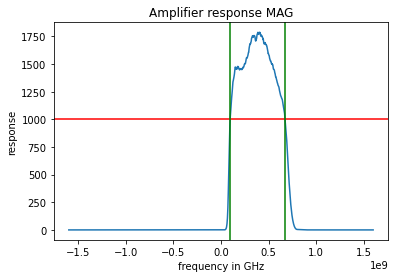

In [48]:
# Freq=np.linspace(0,1*units.GHz, 1000) #np.arange(10**6,10**8,500)#np.arange(4996000,70930000,10000)
print("Amplifier type is: " + GNDetector.get_amplifier_type(StNr,ChNr))
ResponseMag=np.abs(GNDetector.get_amplifier_response(StNr, ChNr, freq*units.Hz))

Crossings = np.where(np.diff(np.sign(ResponseMag-CutOff)))[0]
print("Freq range (GHz):",freq[Crossings]*1e-9)
# Crossings = np.array([np.where(np.diff(np.sign(freq-0.12*1e9)))[0][0],np.where(np.diff(np.sign(freq-0.73*1e9)))[0][0]])
# print(freq)
# print(Crossings)
# print("Freq range (GHz):",freq[Crossings]*1e-9)

plt.figure()#figsize=(20,5))
plt.plot(freq,ResponseMag,'-')#, label="Channel " + str(ChNr))
plt.axhline(y=CutOff, color='r', linestyle='-')
plt.axvline(x=freq[Crossings][0], color='g', linestyle='-')
plt.axvline(x=freq[Crossings][-1], color='g', linestyle='-')
#plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
plt.title("Amplifier response MAG")
#plt.ylim(-50,50)
#plt.xlim(0,1.5*1e9)
plt.ylabel("response")
plt.xlabel("frequency in GHz")
#plt.yscale('log')
#plt.legend()
plt.show()

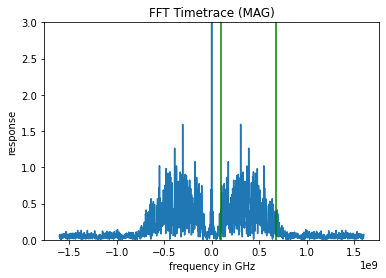

/ada_mnt/ada/user/jstoffels/software/RNOG_venv/lib64/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in cdouble_scalars
/ada_mnt/ada/user/jstoffels/software/RNOG_venv/lib64/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in cdouble_scalars


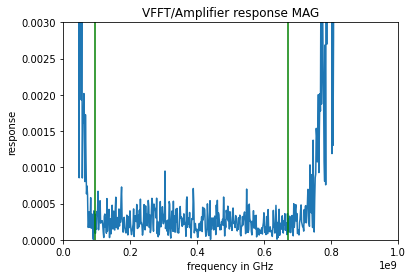

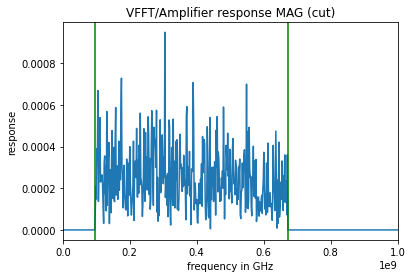

In [49]:
plt.figure()#figsize=(20,5))
plt.plot(freq,np.abs(FFT),'-')#, label="Channel " + str(ChNr))
#plt.axhline(y=CutOff, color='r', linestyle='-')
plt.axvline(x=freq[Crossings][0], color='g', linestyle='-')
plt.axvline(x=freq[Crossings][-1], color='g', linestyle='-')
#plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
plt.title("FFT Timetrace (MAG)")
plt.ylim(0,3)
#plt.xlim(0,1.5*1e9)
plt.ylabel("response")
plt.xlabel("frequency in GHz")
#plt.yscale('log')
#plt.legend()
plt.show()

# FFTD=np.array([FFT[i]/(ResponseMag[i]*(1400/np.max(ResponseMag))) if freq[Crossings][0]<freq[i]<freq[Crossings][-1] else 0 for i in range(len(freq))])
FFTD=np.array([FFT[i]/ResponseMag[i] if freq[Crossings][0]<freq[i]<freq[Crossings][-1] else 0 for i in range(len(freq))])

plt.figure()#figsize=(20,5))
plt.plot(freq,np.abs(np.array([FFT[i]/ResponseMag[i] for i in range(len(freq))])),'-')#, label="Channel " + str(ChNr))
#plt.axhline(y=CutOff, color='r', linestyle='-')
plt.axvline(x=freq[Crossings][0], color='g', linestyle='-')
plt.axvline(x=freq[Crossings][-1], color='g', linestyle='-')
#plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
plt.title("VFFT/Amplifier response MAG")
plt.ylim(0,3*1e-3)
plt.xlim(0,1*1e9)
plt.ylabel("response")
plt.xlabel("frequency in GHz")
#plt.yscale('log')
#plt.legend()
plt.show()

plt.figure()#figsize=(20,5))
plt.plot(freq,np.abs(FFTD),'-')#, label="Channel " + str(ChNr))
#plt.axhline(y=CutOff, color='r', linestyle='-')
plt.axvline(x=freq[Crossings][0], color='g', linestyle='-')
plt.axvline(x=freq[Crossings][-1], color='g', linestyle='-')
#plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
plt.title("VFFT/Amplifier response MAG (cut)")
# plt.ylim(0,3*1e-3)
plt.xlim(0,1*1e9)
plt.ylabel("response")
plt.xlabel("frequency in GHz")
#plt.yscale('log')
#plt.legend()
plt.show()

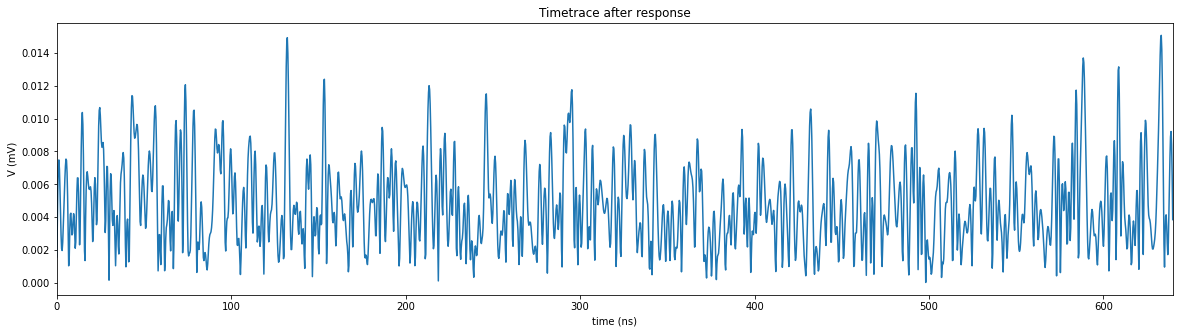

In [50]:
VoltageTracePreAmp=np.abs(scfft.ifft(2*FFTD))
#VoltageTracePreAmp-=np.mean(VoltageTracePreAmp)
plt.figure(figsize=(20,5))
plt.plot(SamplingTimes*1e9,VoltageTracePreAmp*1e3,'-')#, label="Channel " + str(ChNr))
# plt.axhline(y=CutOff, color='r', linestyle='-')
# plt.axvline(x=freq[Crossings][0], color='g', linestyle='-')
# plt.axvline(x=freq[Crossings][-1], color='g', linestyle='-')
#plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
plt.title("Timetrace after response")
#plt.ylim(-50,50)
plt.xlim(0,np.max(SamplingTimes)*1e9)
plt.ylabel("V (mV)")
plt.xlabel("time (ns)")
#plt.yscale('log')
#plt.legend()
plt.show()

$$ V^2/R=P=k_b\cdot T \cdot \Delta \nu$$

In [51]:
VRMS=np.sqrt(np.mean([V**2 for V in VoltageTracePreAmp]))
R,k,df=50,1.38064852 * 1e-23,freq[Crossings][-1]-freq[Crossings][0]
T=(VRMS**2)/(k*R*df)
print("VRMS (mV):",VRMS*1e3)
print("df:",df/1e6,"MHz")
print("Boltzmann cst:",k)
print("T:",T,"K","\n",T-273.15,"C")

VRMS (mV): 0.0054576422641943855
df: 576.8441621885687 MHz
Boltzmann cst: 1.38064852e-23
T: 74.79946518842482 K 
 -198.35053481157516 C


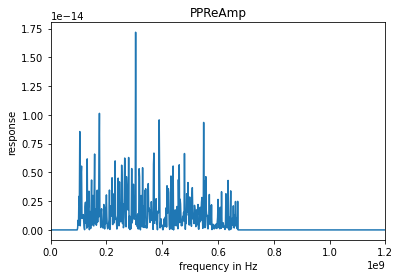

74.79946518842482


In [52]:
PPreAmp=[((V*(2/len(SamplingTimes)))**2)/R for V in np.abs(FFTD) ]

plt.figure()#figsize=(20,5))
plt.plot(freq,np.abs(PPreAmp),'-')#, label="Channel " + str(ChNr))
#plt.axhline(y=CutOff, color='r', linestyle='-')
# plt.axvline(x=freq[Crossings][0], color='g', linestyle='-')
# plt.axvline(x=freq[Crossings][-1], color='g', linestyle='-')
#plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
plt.title("PPReAmp")
# plt.ylim(0,3*1e-3)
plt.xlim(0,1.2*1e9)
plt.ylabel("response")
plt.xlabel("frequency in Hz")
#plt.yscale('log')
#plt.legend()
plt.show()

Ptot=np.sum(np.abs(PPreAmp)) #Total power of the spectrum
# kb=1.38064852 * (10**(-23)) #Boltzmann constant
TempThermal=Ptot/(k*df)
print(TempThermal)

## Same but for an averaged Freq spectrum:

In [1]:
from GalaxyFunctions import *
from NuRadioReco.detector import detector
from NuRadioReco.utilities import units
from datetime import datetime
import scipy.fft as scfft

In [2]:
StNr,ChNr,CutOff,L=23,7,1000,200
PDData=pd.read_pickle("./DSt23.pkl")[:L][["RunNr","EvNr"]]

In [3]:
# AvgFFT=np.zeros(2048,dtype="complex128")#np.empty((2048,0),dtype=object)
FFTs=np.empty((PDData[:L].shape[0],),dtype=object)
for idx,row in PDData[:L].iterrows():
    WaveFormFile=GetWaveformsFile(StNr,row["RunNr"])
    EventNrs=WaveFormFile['event_number'].array(library="np")
    EvIdx=np.where(EventNrs==row["EvNr"])[0][0]
    RadiantData=WaveFormFile['radiant_data[24][2048]'].array(entry_start=EvIdx, entry_stop=EvIdx+1,library='np')
    # HeaderFile=GetHeaderFile(StNr,Run)
    # TriggerTimes=HeaderFile["trigger_time"].array(library='np')
    #EvIdx=np.where(EventNrs==EvNr)[0][0]
    # RadiantData=WaveFormFile['radiant_data[24][2048]'].array(entry_start=EvIdx, entry_stop=EvIdx+1,library='np')
    FFTs[idx]=np.abs(np.fft.fftshift(scfft.fft(ADCtoVoltage(RadiantData[0][ChNr]))))
    del RadiantData, EventNrs

In [18]:
print(FFTs.shape)
AvgFFT=np.mean(FFTs,axis=0)
d = np.stack([Array for Array in FFTs])
MedFFT=np.median(d,axis=0)
print(len(MedFFT))

(200,)
2048


In [69]:
PDData=PDData.assign(FFT=FFTs)

In [100]:
PDData.head()
PDData.loc[0,["FFT","RunNr"]]

array([0.043878  , 0.06944311, 0.05638723, ..., 0.02040559, 0.05638723,
       0.06944311])

In [66]:
sampling_rate=3.2 * (10**9) #Sampling rate in Hertz according to the python file of NuRadioReco.modules.io.rno_g
TimeStep=1/sampling_rate #Time between two samples
SamplingTimes=np.arange(0,2048*TimeStep,TimeStep)
freq=scfft.fftfreq(len(SamplingTimes),(SamplingTimes[-1]-SamplingTimes[0])/len(SamplingTimes))
freq=np.fft.fftshift(freq)

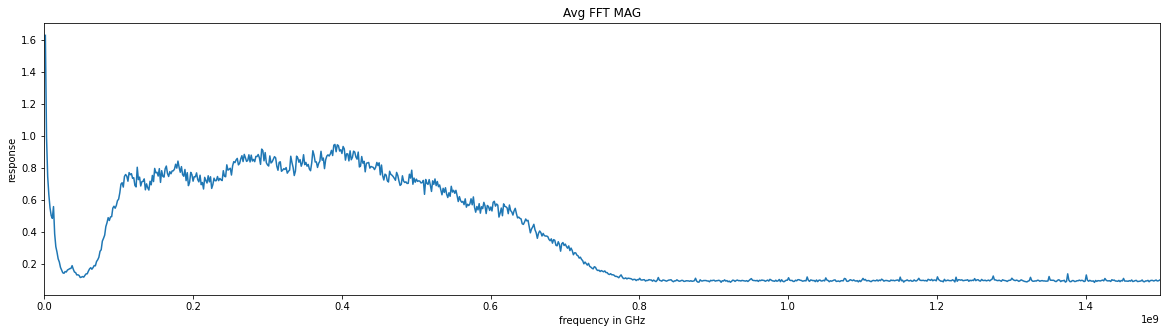

In [67]:
plt.figure(figsize=(20,5))
plt.plot(freq[int(len(FreqSpecs)/2)+1:],2*FreqSpecs[int(len(FreqSpecs)/2)+1:],'-')#, label="Channel " + str(ChNr))
# plt.axhline(y=CutOff, color='r', linestyle='-')
# plt.axvline(x=freq[Crossings][0], color='g', linestyle='-')
# plt.axvline(x=freq[Crossings][-1], color='g', linestyle='-')
#plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
plt.title("Avg FFT MAG")
#plt.ylim(-50,50)
plt.xlim(0,1.5*1e9)
plt.ylabel("response")
plt.xlabel("frequency in GHz")
#plt.yscale('log')
#plt.legend()
plt.show()

In [24]:
Date=datetime.utcfromtimestamp(PDData["Unix"][0])# - timedelta(hours=2, minutes=0)
    
#Obtaining path to relevant json file for detector description
detpath = os.path.dirname(detector.__file__)
detpath+="/RNO_G/RNO_season_2022.json"

#Defining the instances of classes necessary for the simulation
GNDetector = detector.Detector(json_filename = detpath)#,antenna_by_depth=False)
GNDetector.update(Date)

Amplifier type is: iglu
Freq range (GHz): [0.09535906 0.67220322]


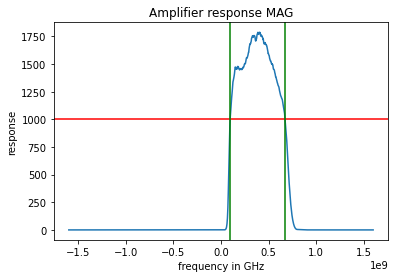

In [25]:
print("Amplifier type is: " + GNDetector.get_amplifier_type(StNr,ChNr))
ResponseMag=np.abs(GNDetector.get_amplifier_response(StNr, ChNr, freq*units.Hz))

Crossings = np.where(np.diff(np.sign(ResponseMag-CutOff)))[0]
print("Freq range (GHz):",freq[Crossings]*1e-9)
# Crossings = np.array([np.where(np.diff(np.sign(freq-0.12*1e9)))[0][0],np.where(np.diff(np.sign(freq-0.73*1e9)))[0][0]])
# print(freq)
# print(Crossings)
# print("Freq range (GHz):",freq[Crossings]*1e-9)

plt.figure()#figsize=(20,5))
plt.plot(freq,ResponseMag,'-')#, label="Channel " + str(ChNr))
plt.axhline(y=CutOff, color='r', linestyle='-')
plt.axvline(x=freq[Crossings][0], color='g', linestyle='-')
plt.axvline(x=freq[Crossings][-1], color='g', linestyle='-')
#plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
plt.title("Amplifier response MAG")
#plt.ylim(-50,50)
#plt.xlim(0,1.5*1e9)
plt.ylabel("response")
plt.xlabel("frequency in GHz")
#plt.yscale('log')
#plt.legend()
plt.show()

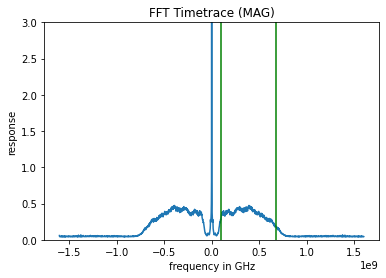

/ada_mnt/ada/user/jstoffels/software/RNOG_venv/lib64/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars


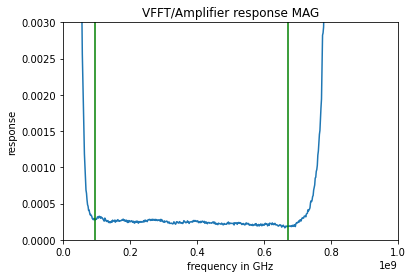

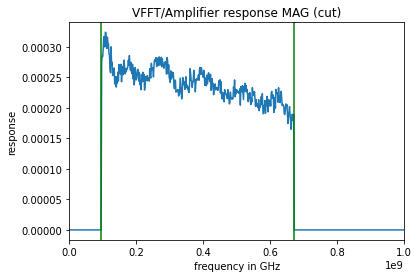

In [27]:
plt.figure()#figsize=(20,5))
plt.plot(freq,np.abs(FreqSpecs),'-')#, label="Channel " + str(ChNr))
#plt.axhline(y=CutOff, color='r', linestyle='-')
plt.axvline(x=freq[Crossings][0], color='g', linestyle='-')
plt.axvline(x=freq[Crossings][-1], color='g', linestyle='-')
#plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
plt.title("FFT Timetrace (MAG)")
plt.ylim(0,3)
#plt.xlim(0,1.5*1e9)
plt.ylabel("response")
plt.xlabel("frequency in GHz")
#plt.yscale('log')
#plt.legend()
plt.show()

# FFTD=np.array([FFT[i]/(ResponseMag[i]*(1400/np.max(ResponseMag))) if freq[Crossings][0]<freq[i]<freq[Crossings][-1] else 0 for i in range(len(freq))])
FFTD=np.array([FreqSpecs[i]/ResponseMag[i] if freq[Crossings][0]<freq[i]<freq[Crossings][-1] else 0 for i in range(len(freq))])

plt.figure()#figsize=(20,5))
plt.plot(freq,np.abs(np.array([FreqSpecs[i]/ResponseMag[i] for i in range(len(freq))])),'-')#, label="Channel " + str(ChNr))
#plt.axhline(y=CutOff, color='r', linestyle='-')
plt.axvline(x=freq[Crossings][0], color='g', linestyle='-')
plt.axvline(x=freq[Crossings][-1], color='g', linestyle='-')
#plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
plt.title("VFFT/Amplifier response MAG")
plt.ylim(0,3*1e-3)
plt.xlim(0,1*1e9)
plt.ylabel("response")
plt.xlabel("frequency in GHz")
#plt.yscale('log')
#plt.legend()
plt.show()

plt.figure()#figsize=(20,5))
plt.plot(freq,np.abs(FFTD),'-')#, label="Channel " + str(ChNr))
#plt.axhline(y=CutOff, color='r', linestyle='-')
plt.axvline(x=freq[Crossings][0], color='g', linestyle='-')
plt.axvline(x=freq[Crossings][-1], color='g', linestyle='-')
#plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
plt.title("VFFT/Amplifier response MAG (cut)")
# plt.ylim(0,3*1e-3)
plt.xlim(0,1*1e9)
plt.ylabel("response")
plt.xlabel("frequency in GHz")
#plt.yscale('log')
#plt.legend()
plt.show()

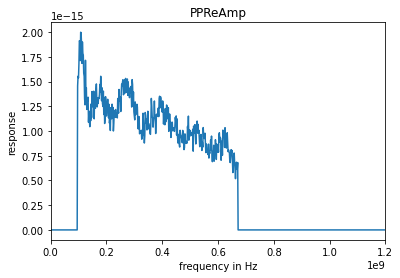

df: 576.8441621885687 MHz
Boltzmann cst: 1.38064852e-23
T: 51.19852481833507 K 
 -221.9514751816649 C


In [30]:
R,k,df=50,1.38064852 * 1e-23,freq[Crossings][-1]-freq[Crossings][0]
PPreAmp=[((V*(2/len(SamplingTimes)))**2)/R for V in np.abs(FFTD) ]

plt.figure()#figsize=(20,5))
plt.plot(freq,np.abs(PPreAmp),'-')#, label="Channel " + str(ChNr))
#plt.axhline(y=CutOff, color='r', linestyle='-')
# plt.axvline(x=freq[Crossings][0], color='g', linestyle='-')
# plt.axvline(x=freq[Crossings][-1], color='g', linestyle='-')
#plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
plt.title("PPReAmp")
# plt.ylim(0,3*1e-3)
plt.xlim(0,1.2*1e9)
plt.ylabel("response")
plt.xlabel("frequency in Hz")
#plt.yscale('log')
#plt.legend()
plt.show()

Ptot=np.sum(np.abs(PPreAmp)) #Total power of the spectrum
# kb=1.38064852 * (10**(-23)) #Boltzmann constant
T=Ptot/(k*df)
print("df:",df/1e6,"MHz")
print("Boltzmann cst:",k)
print("T:",T,"K","\n",T-273.15,"C")

In [44]:
TTArray=np.empty((5,),dtype=object)
for i in range(5):
    TTArray[i]=np.random.uniform(0,5,7)
TTArray=np.stack(TTArray)
print(TTArray)
print(70*"=")
TTArray=np.float32(TTArray)
print(TTArray)
print(type(TTArray[0][0]))
print(np.median(TTArray,axis=0))
print(np.median([A[0] for A in TTArray]))
print(TTArray.shape)

[[0.95544549 2.81329033 2.52698874 2.96438411 2.6226291  4.29740229
  3.51063896]
 [3.11838074 2.59571838 4.31128983 1.08662655 4.38153051 2.43948778
  0.26981679]
 [0.53591029 4.17875111 1.77030218 3.08980447 4.44265701 3.45918989
  0.22035627]
 [3.74627388 3.07279414 1.71980926 2.47177574 4.4754133  4.83179468
  1.74632775]
 [0.06922041 1.7933758  1.24361342 2.25892631 2.48017595 3.71174126
  0.47956176]]
[[0.95544547 2.8132904  2.5269887  2.964384   2.6226292  4.2974024
  3.510639  ]
 [3.1183808  2.5957184  4.31129    1.0866265  4.3815303  2.4394877
  0.2698168 ]
 [0.5359103  4.178751   1.7703022  3.0898044  4.442657   3.45919
  0.22035627]
 [3.746274   3.0727942  1.7198093  2.4717758  4.4754133  4.8317947
  1.7463278 ]
 [0.06922041 1.7933758  1.2436135  2.2589264  2.480176   3.7117412
  0.47956175]]
<class 'numpy.float32'>
[0.95544547 2.8132904  1.7703022  2.4717758  4.3815303  3.7117412
 0.47956175]
0.95544547
(5, 7)


In [29]:
a = np.array([np.array([10, 7, 4]), np.array([3, 2, 1])])
a.shape
# np.median(a, axis=0)

(2, 3)

## Extrapolate from sim & data

In [4]:
import numpy as np

In [6]:
R,k,df=50,1.38064852 * 1e-23,(110-10)*1e6
T0,dVRMS=275,0.119*1e-3
T1=(np.sqrt(T0)-dVRMS/np.sqrt(k*R*df))**2
print(T1)

190388.86350223862


In [10]:
np.sqrt(k*R*df)

2.627402253177081e-07

In [8]:
df

100000000.0